| Swiftest TAP Workshop | Oct. 21, 2025 | Prof. David Minton |
| ----------------------------- | --------- | ------------------ |


> Notes: This tutorial is based on the Basic simulation from the Swiftest User Guide [documentation page](https://swiftest.readthedocs.io/en/latest/user-guide/basic-simulation.html)

> Swiftest uses OpenMP parallelization to help speed up the integration, however the parallelization is most effective when there
    are large numbers of bodies in the simulation. For small numbers of bodies, the overhead of parallelization can actually slow
    the simulation down. The number of threads used by Swiftest can be controlled using the `OMP_NUM_THREADS` environment
    variable. For example, to use 4 threads, you can set the environment variable using the following command in a Unix-like shell:

```python
    export OMP_NUM_THREADS=4
```

In [1]:
# For our example simulations, which only includes the major planets of the solar system, it is best to run the simulation with a single thread. 
import os
os.environ['OMP_NUM_THREADS'] = '1'


Here we will walk you through the basic features of Swiftest and using them in Python. 

Start with importing Swiftest. 

In [2]:
import swiftest

## Initial Simulation Setup 

Create a Swiftest `swiftest.Simulation` object.
Outputs are stored in the ``./simdata`` directory by default. 

In [3]:
sim = swiftest.Simulation()

Reading Swiftest file /Users/daminton/work/Talks/2025-10-TAP_University_of_Arizona/Swiftest_2025_TAP_Workshop/Basic-Simulation/simdata/param.in
codename                         Swiftest
gmtiny                           0.0 DU^3 / TU^2 
mtiny                            0.0 MU
t0                               0.0 TU
tstart                           0.0 TU
tstop                            100000.0 TU
dt                               0.01 TU
istep_out                        100000 
dump_cadence                     0 
tstep_out                        1000.0 TU
init_cond_file_name              init_cond.nc
init_cond_file_type              NETCDF_DOUBLE
init_cond_format                 XV
output_file_type                 NETCDF_DOUBLE
output_file_name                 data.nc
output_format                    XVEL
restart                          REPLACE
rmin                             0.004650467260962157 DU
rmax                             10000.0 DU
qmin_coord                       HELIO
cl

## Solar System Bodies

We can add solar system bodies to the simulation using the :meth:`~swiftest.Simulation.add_solar_system_body` 
method.  This method uses JPL Horizons to extract the parameters. 

In [4]:
# Add the modern planets and the Sun using the JPL Horizons Database.
sim.add_solar_system_body(["Sun","Mercury","Venus","Earth","Mars","Jupiter","Saturn","Uranus","Neptune"])

Adding solar system bodies by name: Sun, Mercury, Venus, Earth, Mars, Jupiter, Saturn, Uranus, Neptune
Creating the Sun as a central body
Fetching ephemerides data for Mercury from JPL/Horizons
Found matching body: Mercury Barycenter (1)
    Alternate matching bodies:
    Mercury (199)
Found ephemerides data for Mercury Barycenter (1) from JPL/Horizons
Physical properties found for Mercury Barycenter (199)
Fetching ephemerides data for Venus from JPL/Horizons
Found matching body: Venus Barycenter (2)
    Alternate matching bodies:
    Venus (299)
Found ephemerides data for Venus Barycenter (2) from JPL/Horizons
Physical properties found for Venus Barycenter (299)
Fetching ephemerides data for Earth from JPL/Horizons
Found matching body: Earth-Moon Barycenter (3)
    Alternate matching bodies:
    Earth (399)
Found ephemerides data for Earth-Moon Barycenter (3) from JPL/Horizons
Found matching body: Earth (399) (399)
Physical properties found for Earth (399)
Combining mass of Earth and 

## Running the Simulation

Before we run the simulation, we need to set some parameters to control the total length and step size of an integration. Swiftest 
sets a Simulation object up with a set of default parameters, including a default unit system of AU, y, and solar masses. However, 
you are required to set the ``tstop`` and ``dt`` parameters before running the simulation. These control the total time of the 
simulation and the time step size, respectively.

> The symplectic integrators used in Swiftest are not adaptive, so the time step size is fixed throughout the simulation.
    Typically you want to choose a step size that is no more than 1/20th of the shortest orbital period in the system. So for the
    solar system, a step size of 0.01 y is a good choice in order to accurately model Mercury's orbit.

Another important consideration is the number of steps you wish to save and how often the output is saved to file (the output 
cadence). By default, Swiftest will save every output step to disk. However, Swiftest is designed to simulate systems for long 
periods of time, so it is often not practical to save every single time step to disk. There are three ways to control how many 
steps are saved to file: `tstep_out`, `istep_out`, and `nstep_out`.

`istep_out`
: This is the integer number of time steps between output saves to file, which can be used to control the output 
  cadence.  For example, if you set `istep_out=1000`, then the simulation will save the system every 1000 time steps. This is 
  useful if you want to save the system every N time steps, regardless of the time interval between steps. 

`tstep_out`
: This is the approximate time interval between output steps. This is the most intuitive way to control the output 
  cadence. It is the time interval between each output step in the simulation. For example, if you set `tstep_out=1e3`, then the 
  simulation will save the system every 1000 y. Internally, Swiftest uses the integer value `istep_out` to control the output 
  cadence, which is computed as:

```python
    istep_out = floor(tstep_out/dt)
```

  Only one of either `tstep_out` or `istep_out` should be set.

`dump_cadence`
: Simulation data is stored in NetCDF format, which is a self-describing binary file format that is widely used in the scientific
community. However, writing to disk is a slow process, so writing to disk can be a bottleneck in the simulation. To mitigate this,
Swiftest has a `dump_cadence` parameter that controls how often the simulation data is written to disk. The integer value passed 
to `dump_cadence` controls the number of output steps (as determined `istep_out`) between when the saved data is dumped to a 
file. The default value is 10, which means that Swiftest will store 10 outputs in memory before dumping them to file. 
Setting `dump_cadence` to 0 is a a special case that tells Swiftest to store *all* output in memory until the end of the 
simulation. This is useful for short simulations, but can be memory intensive for long simulations. 

 >note: Changing the value of ``dump_cadence`` does not change the amount of data that is output by the end of the simulation. It only
  changes how often the data is written to disk. Changing the value of ``tstep_out`` (or ``istep_out``) *does* change the amount of
  data that is output by the end of the simulation. Intermediate steps between output steps are not saved to disk, and cannot be
  recovered after the simulation has finished.

The choice of what values to set for `tstep_out` (or `istep_out`), `nstep_out`, and `dump_cadence` depends on the particular
simulation. Higher values of `dump_cadence` are typically useful for simulations with small numbers of bodies and small values
of `tstep_out` where frequent writing to disk can severely impact performance. For simulations with large numbers of bodies and 
larger values of `tstep_out`, it is often better to set `dump_cadence` to a smaller value and write the data to disk more often
so that the memory usage does not become too large. The default value of `dump_cadence` of 10 is a good compromise for most use
caes.

We can set these simulation parameters using the `Simulation.set_parameter` method. 
Here we have a simulation that runs for 100,000 y a step size of 0.01 y. We will also save the system every 1000 y and wait until the end
of the simulation to write the simulation data to file using the `dump_cadence=0` argument

In [5]:
sim.set_parameter(tstop=1.0e5, tstep_out=1e3, dt=0.01, dump_cadence=0)

codename                         Swiftest
tstop                            100000.0 TU
dt                               0.01 TU
istep_out                        100000 
dump_cadence                     0 
tstep_out                        1000.0 TU


{'TSTOP': 100000.0, 'DT': 0.01, 'ISTEP_OUT': 100000, 'DUMP_CADENCE': 0}

Once everything is set up, we call the `run` method to integrate the system forward in time

In [6]:
sim.run()

Cleaning up simulation directory /Users/daminton/work/Talks/2025-10-TAP_University_of_Arizona/Swiftest_2025_TAP_Workshop/Basic-Simulation/simdata of old output files.
Writing initial conditions to file /Users/daminton/work/Talks/2025-10-TAP_University_of_Arizona/Swiftest_2025_TAP_Workshop/Basic-Simulation/simdata/init_cond.nc
Writing parameter inputs to file /Users/daminton/work/Talks/2025-10-TAP_University_of_Arizona/Swiftest_2025_TAP_Workshop/Basic-Simulation/simdata/param.in
Writing parameter inputs to file /Users/daminton/work/Talks/2025-10-TAP_University_of_Arizona/Swiftest_2025_TAP_Workshop/Basic-Simulation/simdata/param.in
Running a Swiftest symba run from tstart=0.0 TU to tstop=100000.0 TU
 OpenMP: Number of threads =   1
[################################################################################] Time =  1.00000E+05 of  1.00000E+05
Run complete.

Creating Dataset from NetCDF file
Successfully converted 101 output frames.
Swiftest simulation data stored as xarray Dataset 

Swiftest is relatively flexible with arguments. You can pass the parameters in when initializing the simulation object, or even later when running.
So the following are all equivalent:
```
    sim = swiftest.Simulation(tstop=1.0e5, tstep_out=1e3, dt=0.01, dump_cadence=0)
    sim.add_solar_system_body(["Sun","Mercury","Venus","Earth","Mars","Jupiter","Saturn","Uranus","Neptune"])
    sim.run()

    sim = swiftest.Simulation()
    sim.add_solar_system_body(["Sun","Mercury","Venus","Earth","Mars","Jupiter","Saturn","Uranus","Neptune"])
    sim.set_parameter(tstop=1.0e6, tstep_out=1e3, dt=0.01, dump_cadence=0)
    sim.run()

    sim = swiftest.Simulation()
    sim.add_solar_system_body(["Sun","Mercury","Venus","Earth","Mars","Jupiter","Saturn","Uranus","Neptune"])
    sim.run(tstop=1.0e5, tstep_out=1e3, dt=0.01, dump_cadence=0)
```

## Analayzing Simulation Output

Once a simulation has been run, its output data is stored in the `./simdata` directory. The main data is stored in a file with a 
default name of `data.nc`, which is a netCDF file. It is read in and stored as an 
[Xarray Dataset](https://docs.xarray.dev/en/stable/) object in the `swiftest.Simulation.data` attribute.

Here is an example of what the dataset looks like after the above simulation has been run

In [7]:
sim.data

<xarray.SwiftestDataset> Size: 242kB
Dimensions:          (name: 9, time: 101, space: 3)
Coordinates:
  * name             (name) <U32 1kB 'Sun' 'Mercury' ... 'Uranus' 'Neptune'
  * time             (time) float64 808B 0.0 1e+03 2e+03 ... 9.9e+04 1e+05
  * space            (space) <U1 12B 'x' 'y' 'z'
Data variables: (12/48)
    id               (name) int64 72B 0 1 2 3 4 5 6 7 8
    status           (time, name) int64 7kB 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    npl              (time) int64 808B 8 8 8 8 8 8 8 8 8 8 ... 8 8 8 8 8 8 8 8 8
    ntp              (time) int64 808B 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    nplm             (time) int64 808B 8 8 8 8 8 8 8 8 8 8 ... 8 8 8 8 8 8 8 8 8
    particle_type    (name) <U32 1kB 'Central Body' ... 'Massive Body'
    ...               ...
    L_orbit          (time, space) float64 2kB 0.0005832 0.0001848 ... 0.0222
    L_rot            (time, space) float64 2kB 1.697e-05 ... 0.0001249
    L_escape         (time, space) float64 2kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    E_collisions     (time) float64 808B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    E_untracked      (time) float64 808B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    GMescape         (time) float64 808B 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

As you can see, even in this very simple example, the dataset contains a large amount of information about the simulated system. 
For details about the definitions of *variables*, *dimensions*, and *coordinates*, see the 
[terminology](https://docs.xarray.dev/en/stable/user-guide/terminology.html) section of the Xarray documentation. Xarray 
Datasets are very powerful and flexible, and can be used to analyze and visualize the simulation data in a variety of ways. 
Here is an example where we can generate a simple plot of the semimajor axis vs. time history of all the planets in the system

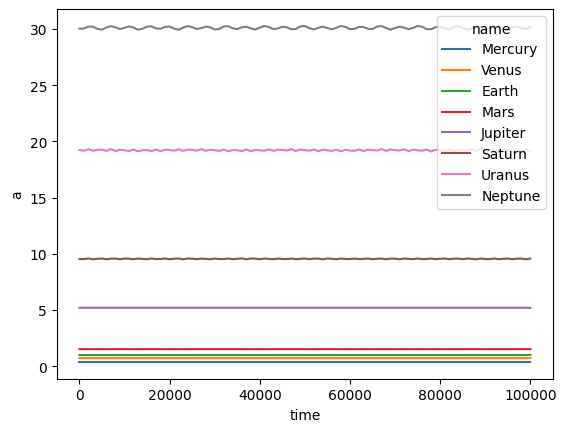

In [8]:
sim.data['a'].where(sim.data.particle_type != 'Central Body', drop=True).plot(x='time',hue='name')

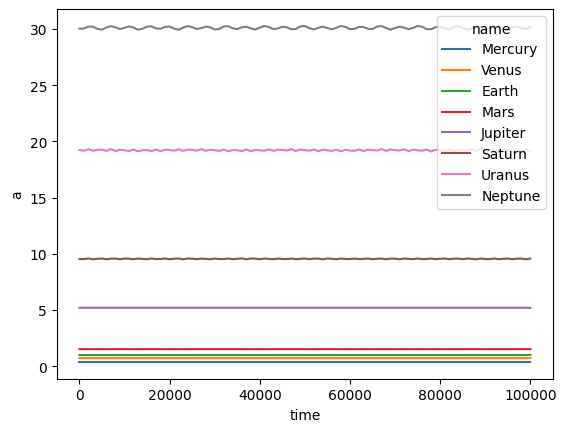

In [9]:
sim.data['a'].where(sim.data.particle_type != 'Central Body', drop=True).plot(x='time',hue='name');

This is just a simple example of what you can do with the simulation data. Xarray has a large number of built-in plotting and 
data processing functions. For more information, see the [Xarray documentation](https://docs.xarray.dev/en/stable/).